# Down sizing the image

In [6]:
import cv2

# Load the image
image_path = r'C:\\Users\\VUW\\Documents\\Desktop\\NewFolder\\FilmS5.png'  # Replace with your image file path

image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is None:
    print("Error: Could not load image. Please check the file path.")
else:
    # Get the current size of the image
    current_height, current_width = image.shape[:2]
    print(f'Current size of the image: Width = {current_width}, Height = {current_height}')

    # Specify the new width and height
    new_width = 800  # Change to desired width
    new_height = 800  # Change to desired height

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Save the resized image
    resized_image_path = r'C:\\Users\\VUW\\Documents\\Desktop\\NewFolder\\FilmS5-800.png'  # Output path
    cv2.imwrite(resized_image_path, resized_image)

    # Optionally, display the original and resized images
    #cv2.imshow('Original Image', image)
    #cv2.imshow('Resized Image', resized_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

Current size of the image: Width = 16412, Height = 16412


# Converts input to grayscale (no blurring) >>> Applies threshold to create binary image, and >>> Displays histograms for analysis


In [7]:
import cv2
import numpy as np
import os
import shutil

# Specify the path to your image
#image should be in the same directory are the Python file!
image_path = 'FilmS5-800.png'    # Update the path to your image

# Get the base filename without extension to use as folder name
base_filename = os.path.splitext(os.path.basename(image_path))[0]

# Create a new directory with the base filename
output_dir = os.path.join('.', f"{base_filename}_preprocessing")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Copy the original image to the output directory
shutil.copy(image_path, os.path.join(output_dir, 'original_image.png'))

# Load image in grayscale for processing
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_GrayScale = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Apply Gaussian blur (based on need)
kernel_size = (5, 5)  # You can adjust the kernel size as needed
img_blurred = cv2.GaussianBlur(img, kernel_size, sigmaX=0)  # Apply Gaussian blur

# Save the blurred grayscale image (optional)
cv2.imwrite(os.path.join(output_dir, 'step_1_GrayScale_image_blurred.png'), img_blurred)

# Thresholding setup
chosen_static_threshold_value = 100  # Placeholder for a static threshold value

# Apply static thresholding
_, img_binary = cv2.threshold(img_blurred, chosen_static_threshold_value, 255, cv2.THRESH_BINARY)  # Use blurred image for thresholding

# Save binary image
cv2.imwrite(os.path.join(output_dir, 'step_2_binary_image.png'), img_binary)

print(f"Preprocessing completed!")
print(f"Original image saved as: {os.path.join(output_dir, 'original_image.png')}")
print(f"Blurred grayscale saved as: {os.path.join(output_dir, 'step_1_GrayScale_image_blurred.png')}")
print(f"Binary image saved as: {os.path.join(output_dir, 'step_2_binary_image.png')}")
print(f"Use the binary image as input for the main analysis code.")

Preprocessing completed!
Original image saved as: .\s5-800_preprocessing\original_image.png
Blurred grayscale saved as: .\s5-800_preprocessing\step_1_GrayScale_image_blurred.png
Binary image saved as: .\s5-800_preprocessing\step_2_binary_image.png
Use the binary image as input for the main analysis code.


# Junction and effective segment detection


=== ENDPOINT BRANCH PRUNING ===
Minimum branch length threshold: 50 pixels
Pruning iteration 1...
  Removed 902 short branches
Pruning iteration 2...
  Removed 126 short branches
Pruning iteration 3...
  Removed 29 short branches
Pruning iteration 4...
  Removed 6 short branches
Pruning iteration 5...
  Removed 1 short branches
Pruning iteration 6...
No more endpoints found.
Branch pruning completed after 6 iterations
Total branches removed: 1064
Total pixels removed: 6281
Average removed branch length: 5.9 pixels
Removed branch lengths - Min: 1, Max: 43

=== SEGMENT ANALYSIS (on pruned skeleton) ===

Segment Analysis:
Junction removal radius: 4 pixels
Junction diameter: 8 pixels
Junction diameter multiplier: 1
Minimum segment length threshold (1 junction diameters): 8 pixels
Number of Valid Segments (connecting 2+ junctions OR edge+junction, longer than 1 junction diameters): 1125
  - Edge-connected segments: 79
Number of Short Segments (excluded for being shorter than 1 junction dia

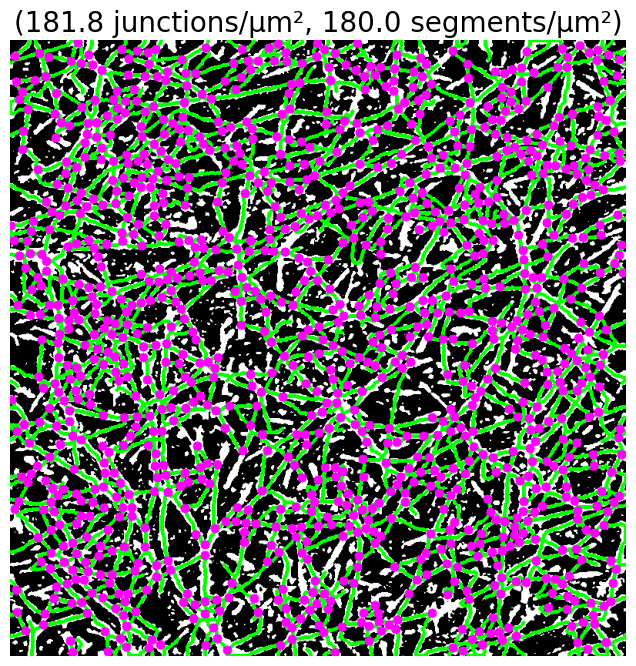

In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import morphology  # Importing required library for morphology operations
import shutil  # Import the shutil library for file operations
import random
import pandas as pd

def getSkeletonJunctions(skeleton, discard_radius=3.4):
    '''
    Given a skeletonized image, return the junctions of the skeleton that are outside of some discard radius from each other.
    '''
    # Check if the central point is surrounded by three others
    im = skeleton.copy()
    imxorx = (im[:-1, :] ^ im[1:, :]) // 255
    imxory = (im[:, :-1] ^ im[:, 1:]) // 255
    imxor = ((imxorx[:-1, :-2] + imxorx[1:, :-2] + imxorx[:-1, 2:] + imxorx[1:, 2:] +
              imxory[:-2, :-1] + imxory[:-2, 1:] + imxory[2:, :-1] + imxory[2:, 1:])
             * (im[1:-1, 1:-1] // 255))
    junctions = np.argwhere(imxor.T >= 6) + (1, 1)

    # Remove junctions that are too close together
    good_junctions = []
    discard_radius_sq = discard_radius**3.4
    for p1 in junctions:
        if all(np.sum((p1 - p2) ** 2) >= discard_radius_sq for p2 in good_junctions):
            good_junctions.append(p1)
    return good_junctions

def find_endpoints(skeleton):
    '''
    Find all endpoint pixels in a skeletonized image.
    An endpoint has exactly one neighbor.
    '''
    # Create a kernel to count neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.uint8)
    
    # Convert skeleton to binary (0 or 1)
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    
    # Count neighbors for each pixel
    neighbor_count = cv2.filter2D(skeleton_binary, -1, kernel)
    
    # Endpoints are skeleton pixels with exactly 1 neighbor
    endpoints = np.logical_and(skeleton_binary == 1, neighbor_count == 1)
    
    return endpoints

def trace_branch_from_endpoint(skeleton, start_point, max_length):
    '''
    Trace a branch from an endpoint until reaching a junction or max_length.
    Returns the pixels in the branch path.
    '''
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    visited = np.zeros_like(skeleton_binary, dtype=bool)
    branch_pixels = []
    
    # Start from the endpoint
    current = start_point
    branch_pixels.append(current)
    visited[current[0], current[1]] = True
    
    while len(branch_pixels) < max_length:
        # Find neighbors of current pixel
        neighbors = []
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = current[0] + dy, current[1] + dx
                if (0 <= ny < skeleton_binary.shape[0] and 
                    0 <= nx < skeleton_binary.shape[1] and
                    skeleton_binary[ny, nx] == 1 and
                    not visited[ny, nx]):
                    neighbors.append((ny, nx))
        
        if len(neighbors) == 0:
            # Dead end reached
            break
        elif len(neighbors) == 1:
            # Continue along the branch
            current = neighbors[0]
            branch_pixels.append(current)
            visited[current[0], current[1]] = True
        else:
            # Junction reached, stop here
            break
    
    return branch_pixels

def remove_short_endpoint_branches(skeleton, min_branch_length=50):
    '''
    Remove endpoint branches that are shorter than min_branch_length pixels.
    
    Args:
        skeleton: Binary skeletonized image
        min_branch_length: Minimum length to keep a branch (in pixels)
    
    Returns:
        Cleaned skeleton with short endpoint branches removed
    '''
    print(f"\n=== ENDPOINT BRANCH PRUNING ===")
    print(f"Minimum branch length threshold: {min_branch_length} pixels")
    
    # Create a copy to work with
    cleaned_skeleton = skeleton.copy()
    
    # Track removed branches for statistics
    removed_branches = []
    total_removed_pixels = 0
    
    iteration = 0
    max_iterations = 10  # Prevent infinite loops
    
    while iteration < max_iterations:
        iteration += 1
        print(f"Pruning iteration {iteration}...")
        
        # Find current endpoints
        endpoints = find_endpoints(cleaned_skeleton)
        endpoint_coords = np.argwhere(endpoints)
        
        if len(endpoint_coords) == 0:
            print("No more endpoints found.")
            break
        
        branches_removed_this_iteration = 0
        
        # Process each endpoint
        for endpoint in endpoint_coords:
            # Check if this endpoint still exists (might have been removed in previous branch removal)
            if cleaned_skeleton[endpoint[0], endpoint[1]] == 0:
                continue
                
            # Trace branch from this endpoint
            branch_pixels = trace_branch_from_endpoint(cleaned_skeleton, endpoint, min_branch_length + 10)
            
            # If branch is shorter than threshold, remove it
            if len(branch_pixels) < min_branch_length:
                # Remove this branch
                for pixel in branch_pixels:
                    cleaned_skeleton[pixel[0], pixel[1]] = 0
                
                removed_branches.append(len(branch_pixels))
                total_removed_pixels += len(branch_pixels)
                branches_removed_this_iteration += 1
        
        print(f"  Removed {branches_removed_this_iteration} short branches")
        
        if branches_removed_this_iteration == 0:
            print("No more short branches to remove.")
            break
    
    print(f"Branch pruning completed after {iteration} iterations")
    print(f"Total branches removed: {len(removed_branches)}")
    print(f"Total pixels removed: {total_removed_pixels}")
    if removed_branches:
        print(f"Average removed branch length: {np.mean(removed_branches):.1f} pixels")
        print(f"Removed branch lengths - Min: {min(removed_branches)}, Max: {max(removed_branches)}")
    
    return cleaned_skeleton

def is_connected_to_edge(segment_mask):
    '''
    Check if a segment is connected to any edge of the image.
    Returns True if segment touches image boundary.
    '''
    height, width = segment_mask.shape
    segment_pixels = np.argwhere(segment_mask)
    
    for pixel in segment_pixels:
        y, x = pixel
        # Check if pixel is on any edge
        if y == 0 or y == height - 1 or x == 0 or x == width - 1:
            return True
    return False

def remove_isolated_objects(labeled_objects):
    '''
    Remove objects that are not connected to the image edges.
    Returns labeled objects with isolated objects removed.
    '''
    # Create a copy to work with
    filtered_objects = labeled_objects.copy()
    
    # Get unique object labels (excluding background 0)
    unique_labels = np.unique(labeled_objects)
    unique_labels = unique_labels[unique_labels > 0]
    
    for label in unique_labels:
        # Create mask for current object
        object_mask = (labeled_objects == label)
        
        # Check if object is connected to edge
        if not is_connected_to_edge(object_mask):
            # Remove isolated object by setting its pixels to 0
            filtered_objects[object_mask] = 0
    
    return filtered_objects

def count_junction_connections(segment_mask, junctions, search_radius=5):
    '''
    Count how many junctions a segment is connected to within a search radius.
    Also checks if segment is connected to image edge (counts as +1 connection).
    Returns the number of connected junctions + edge connections.
    '''
    connection_count = 0
    
    # Check edge connection first
    if is_connected_to_edge(segment_mask):
        connection_count += 1
    
    if len(junctions) == 0:
        return connection_count
    
    # Get segment pixels
    segment_pixels = np.argwhere(segment_mask)
    
    connected_junctions = set()
    
    # Check connection to each junction
    for junction_idx, junction in enumerate(junctions):
        for seg_pixel in segment_pixels:
            # Calculate distance between segment pixel and junction
            distance = np.sqrt(np.sum((seg_pixel - junction[::-1]) ** 2))  # Note: junction coords are (x,y), segment coords are (y,x)
            if distance <= search_radius:
                connected_junctions.add(junction_idx)
                break  # No need to check more pixels for this junction
    
    return connection_count + len(connected_junctions)

def calculate_segment_length(segment_mask):
    '''
    Calculate the actual path length of a segment by tracing connected pixels.
    Returns the length in pixels.
    '''
    segment_pixels = np.argwhere(segment_mask)
    if len(segment_pixels) <= 1:
        return len(segment_pixels)
    
    # For skeletonized images, the segment length is approximately the number of pixels
    # since skeleton lines are single-pixel width
    return len(segment_pixels)

def get_junction_size_threshold(junction_removal_radius=3, junction_diameter_multiplier=3):
    '''
    Calculate the minimum segment length based on junction size.
    Segments shorter than the specified number of junction diameters are considered too short.
    
    Args:
        junction_removal_radius: Radius used to remove junctions (from getSkeletonJunctions)
        junction_diameter_multiplier: Number of junction diameters to use as threshold (e.g., 2, 3, 4)
    
    Returns:
        Minimum acceptable segment length in pixels
    '''
    # Junction diameter = 2 * radius
    junction_diameter = 2 * junction_removal_radius
    # Minimum segment length = junction_diameter_multiplier * junction_diameter
    min_segment_length = junction_diameter_multiplier * junction_diameter
    return min_segment_length

def count_and_visualize_segments(skeleton, junctions, junction_removal_radius=3, junction_diameter_multiplier=3):
    '''
    Count the number of segments (excluding isolated lines and endpoints) and create a visualization.
    Only counts segments that connect to 2 or more junctions AND are longer than the specified junction diameter threshold.
    
    Args:
        skeleton: Binary skeleton image
        junctions: Array of junction coordinates from getSkeletonJunctions (format: list of [x,y] coordinates)
        junction_removal_radius: Radius used for junction removal (should match getSkeletonJunctions)
        junction_diameter_multiplier: Number of junction diameters to use as threshold for short segments
    '''
    # Convert junctions to numpy array if it's a list
    if isinstance(junctions, list):
        junctions = np.array(junctions)
    
    # Calculate minimum acceptable segment length based on junction size
    min_segment_length = get_junction_size_threshold(junction_removal_radius, junction_diameter_multiplier)
    
    print(f"\nSegment Analysis:")
    print(f"Junction removal radius: {junction_removal_radius} pixels")
    print(f"Junction diameter: {2 * junction_removal_radius} pixels")
    print(f"Junction diameter multiplier: {junction_diameter_multiplier}")
    print(f"Minimum segment length threshold ({junction_diameter_multiplier} junction diameters): {min_segment_length} pixels")
    
    # Create a copy of the skeleton and remove junctions to isolate segments
    skeleton_clean = skeleton.copy()
    
    # Mark junctions (to avoid misclassifying them as part of a segment)
    for j in junctions:
        cv2.circle(skeleton_clean, tuple(j), 3, 0, -1)  # Remove junctions
    
    # Label connected components (segments)
    num_labels, labels = cv2.connectedComponents(skeleton_clean, connectivity=8)
    
    # Filter segments: only keep those connected to 2 or more junctions OR connected to edge + 1 junction
    # AND are longer than the specified junction diameter threshold
    valid_segments = []
    valid_segment_labels = []
    endpoint_segments = []
    isolated_segments = []
    edge_connected_segments = []
    short_segments = []  # New category for segments shorter than specified junction diameter threshold
    
    # Store segment lengths for Excel export
    segment_lengths_data = []
    
    for i in range(1, num_labels):  # Skip background (label 0)
        segment_mask = labels == i
        
        # Calculate segment length
        segment_length = calculate_segment_length(segment_mask)
        
        # Count how many junctions this segment connects to (including edge connections)
        junction_connections = count_junction_connections(segment_mask, junctions)
        edge_connected = is_connected_to_edge(segment_mask)
        
        # Check if segment meets length requirement (longer than specified junction diameter threshold)
        meets_length_requirement = segment_length >= min_segment_length
        
        if junction_connections >= 2:
            # Potentially valid segment (connects 2+ junctions OR edge + 1 junction)
            if meets_length_requirement:
                valid_segments.append(i)
                valid_segment_labels.append(len(valid_segments))  # Renumber segments
                if edge_connected:
                    edge_connected_segments.append(i)
                # Add to data
                segment_lengths_data.append({
                    'Segment_Type': 'Valid',
                    'Segment_ID': i,
                    'Length_Pixels': segment_length,
                    'Edge_Connected': edge_connected
                })
            else:
                short_segments.append(i)  # Shorter than specified junction diameter threshold, exclude
                # Add to data
                segment_lengths_data.append({
                    'Segment_Type': 'Short',
                    'Segment_ID': i,
                    'Length_Pixels': segment_length,
                    'Edge_Connected': edge_connected
                })
        elif junction_connections == 1:
            # Endpoint segment (connects to only 1 junction and no edge)
            if edge_connected and meets_length_requirement:
                # Edge-connected segment with 1 junction (valid due to edge connection)
                valid_segments.append(i)
                valid_segment_labels.append(len(valid_segments))
                edge_connected_segments.append(i)
                # Add to data
                segment_lengths_data.append({
                    'Segment_Type': 'Valid',
                    'Segment_ID': i,
                    'Length_Pixels': segment_length,
                    'Edge_Connected': edge_connected
                })
            elif edge_connected and not meets_length_requirement:
                short_segments.append(i)  # Edge-connected but shorter than specified junction diameter threshold
                # Add to data
                segment_lengths_data.append({
                    'Segment_Type': 'Short',
                    'Segment_ID': i,
                    'Length_Pixels': segment_length,
                    'Edge_Connected': edge_connected
                })
            else:
                endpoint_segments.append(i)
                # Endpoint segments are excluded from data export
        else:
            # Isolated segment (connects to no junctions)
            if edge_connected:
                # Edge-only connection
                if meets_length_requirement:
                    endpoint_segments.append(i)  # Count as endpoint since only one connection
                    # Endpoint segments are excluded from data export
                else:
                    short_segments.append(i)  # Shorter than specified junction diameter threshold
                    # Add to data
                    segment_lengths_data.append({
                        'Segment_Type': 'Short',
                        'Segment_ID': i,
                        'Length_Pixels': segment_length,
                        'Edge_Connected': edge_connected
                    })
            else:
                isolated_segments.append(i)
                # Isolated segments are excluded from data export
    
    # Count valid segments only
    num_segments = len(valid_segments)
    
    # Create visualization
    height, width = skeleton.shape
    colored_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Generate light blue variations for each valid segment
    colors = []
    for i in range(num_segments + 1):
        if i == 0:  # Background
            colors.append([0, 0, 0])
        else:
            # Generate different shades of light blue (RGB format)
            # Base light blue is (255, 255, 0), we'll create variations
            red_intensity = random.randint(200, 255)   # Keep red high for light blue
            green_intensity = random.randint(200, 255) # Keep green high for light blue
            blue_component = random.randint(0, 100)    # Keep blue low for light blue
            colors.append([
                red_intensity,       # Red component (high)
                green_intensity,     # Green component (high)
                blue_component       # Blue component (low)
            ])
    
    # Color each valid segment
    for idx, segment_id in enumerate(valid_segments):
        mask = labels == segment_id
        colored_image[mask] = colors[idx + 1]  # +1 because colors[0] is background
    
    # Count different types of segments for comparison
    total_segments = np.max(labels)
    num_endpoints = len(endpoint_segments)
    num_isolated = len(isolated_segments)
    num_edge_connected = len(edge_connected_segments)
    num_short = len(short_segments)
    
    # Print results
    print(f"Number of Valid Segments (connecting 2+ junctions OR edge+junction, longer than {junction_diameter_multiplier} junction diameters): {num_segments}")
    print(f"  - Edge-connected segments: {num_edge_connected}")
    print(f"Number of Short Segments (excluded for being shorter than {junction_diameter_multiplier} junction diameters): {num_short}")
    print(f"Number of Endpoint Lines (excluded): {num_endpoints}")
    print(f"Number of Isolated Lines (excluded): {num_isolated}")
    print(f"Total Segments (including all types): {total_segments}")
    
    # Print valid segment information
    if num_segments > 0:
        print(f"\nValid Segment Details (longer than {junction_diameter_multiplier} junction diameters):")
        for idx, segment_id in enumerate(valid_segments):
            segment_pixels = np.sum(labels == segment_id)
            edge_status = " (edge-connected)" if segment_id in edge_connected_segments else ""
            print(f"Segment {idx + 1}: {segment_pixels} pixels{edge_status}")
    
    return num_segments, colored_image, labels, valid_segments, endpoint_segments, isolated_segments, edge_connected_segments, short_segments, segment_lengths_data

# Parameters for segment analysis
junction_diameter_multiplier = 1  # Number of junction diameters for short segment threshold
image_size_um = 2.5 # Physical size of the image in micrometers (assumes square image) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
endpoint_branch_threshold = 50  # NEW: Minimum length for endpoint branches (in pixels)

# Specify the path to your image
#image should be in the same directory are the Python file!
image_path = 'step_2_binary_image.png'    # Update the path to your image >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Get the base filename without extension to use as folder name
base_filename = os.path.splitext(os.path.basename(image_path))[0]

# Create a new directory with the base filename
output_dir = os.path.join('.', f"{base_filename}_j")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load image in grayscale for processing
img_binary = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Copy the binary image to the output directory as original
shutil.copy(image_path, os.path.join(output_dir, 'original_image.png'))

# Load the binary image as original image and convert to color for overlay
original_image = cv2.imread(os.path.join(output_dir, 'original_image.png'))

# Save binary image
cv2.imwrite(os.path.join(output_dir, 'step_2_binary_image.png'), img_binary)

# Identify connected components (objects) in the binary image
objects = morphology.label(img_binary)

# Remove small objects (smaller than 100 pixels)
large_objects = morphology.remove_small_objects(objects, min_size=100)

# Remove isolated objects (objects not connected to edges)
large_objects = remove_isolated_objects(large_objects)

small_objects = objects ^ large_objects  # XOR operation to get smaller and isolated objects

# Create binary images from the segmented objects
large_objects_binary = (large_objects > 0).astype(np.uint8) * 255  # Convert to binary format
small_objects_binary = (small_objects > 0).astype(np.uint8) * 255  # Convert to binary format

# Save the separated objects for visualization (optional)
cv2.imwrite(os.path.join(output_dir, 'step_3_large_objects.png'), large_objects_binary)
cv2.imwrite(os.path.join(output_dir, 'step_4_small_objects.png'), small_objects_binary)

# Skeletonize the binary image of large objects
img_skeletonized = cv2.ximgproc.thinning(large_objects_binary)
cv2.imwrite(os.path.join(output_dir, 'step_5_skeletonized_image.png'), img_skeletonized)

# NEW STEP: Remove short endpoint branches from the skeleton
img_skeletonized_pruned = remove_short_endpoint_branches(img_skeletonized, endpoint_branch_threshold)
cv2.imwrite(os.path.join(output_dir, 'step_5b_skeleton_pruned.png'), img_skeletonized_pruned)

# Find junctions using the PRUNED skeleton (this is the key change!)
junctions = getSkeletonJunctions(img_skeletonized_pruned, 4)

# NEW: Segment analysis using the PRUNED skeletonized image
print(f"\n=== SEGMENT ANALYSIS (on pruned skeleton) ===")
num_segments, colored_segments, segment_labels, valid_segments, endpoint_segments, isolated_segments, edge_connected_segments, short_segments, segment_lengths_data = count_and_visualize_segments(
    img_skeletonized_pruned, junctions, junction_removal_radius=4, junction_diameter_multiplier=junction_diameter_multiplier
)

# Calculate densities (similar to second code)
height_pixels, width_pixels = img_skeletonized_pruned.shape
print(f"\nImage dimensions: {width_pixels} × {height_pixels} pixels")
print(f"Physical image size: {image_size_um} × {image_size_um} μm")

# Calculate pixel size in nanometers (assuming square pixels)
pixel_size_nm = (image_size_um * 1000) / width_pixels  # Convert μm to nm and divide by pixels
print(f"Pixel size: {pixel_size_nm:.3f} nm/pixel")

# Calculate image area in square micrometers
image_area_um2 = image_size_um * image_size_um

# Calculate densities
junction_density = len(junctions) / image_area_um2  # junctions per μm²
segment_density = num_segments / image_area_um2    # segments per μm²

print(f"\nDENSITY ANALYSIS:")
print(f"Junction Density: {junction_density:.3f} j/μm²")
print(f"Network Density: {segment_density:.3f} segments/μm²")
if len(junctions) > 0:
    print(f"Valid Segments/Junctions Ratio: {num_segments / len(junctions):.2f}")

# Save segment lengths to Excel file with conversion information
if segment_lengths_data:
    # Convert pixel lengths to nanometers and add conversion info
    for segment in segment_lengths_data:
        segment['Length_nm'] = segment['Length_Pixels'] * pixel_size_nm
    
    df = pd.DataFrame(segment_lengths_data)
    
    # Calculate mean and standard deviation for valid segments only
    valid_segments_data = [s for s in segment_lengths_data if s['Segment_Type'] == 'Valid']
    if valid_segments_data:
        valid_lengths_pixels = [s['Length_Pixels'] for s in valid_segments_data]
        valid_lengths_nm = [s['Length_nm'] for s in valid_segments_data]
        
        mean_length_pixels = np.mean(valid_lengths_pixels)
        std_length_pixels = np.std(valid_lengths_pixels)
        mean_length_nm = np.mean(valid_lengths_nm)
        std_length_nm = np.std(valid_lengths_nm)
    else:
        mean_length_pixels = 0
        std_length_pixels = 0
        mean_length_nm = 0
        std_length_nm = 0
    
    # Create a summary sheet with conversion information
    conversion_info = {
        'Parameter': [
            'Image Width (pixels)',
            'Image Height (pixels)', 
            'Physical Image Size (μm)',
            'Image Area (μm²)',
            'Pixel Size (nm/pixel)',
            'Endpoint Branch Threshold (pixels)',
            'Number of Junctions',
            'Junction Density (j/μm²)',
            'Total Valid Segments',
            'Network Density (segments/μm²)',
            'Mean Segment Length (pixels)',
            'Standard Deviation Length (pixels)',
            'Mean Segment Length (nm)',
            'Standard Deviation Length (nm)',
            'Junction Diameter Multiplier',
            'Short Segment Threshold (pixels)',
            'Total Short Segments',
            'Analysis Date'
        ],
        'Value': [
            width_pixels,
            height_pixels,
            f"{image_size_um} × {image_size_um}",
            f"{image_area_um2:.3f}",
            f"{pixel_size_nm:.3f}",
            endpoint_branch_threshold,
            len(junctions),
            f"{junction_density:.3f}",
            len([s for s in segment_lengths_data if s['Segment_Type'] == 'Valid']),
            f"{segment_density:.3f}",
            f"{mean_length_pixels:.3f}",
            f"{std_length_pixels:.3f}",
            f"{mean_length_nm:.3f}",
            f"{std_length_nm:.3f}",
            junction_diameter_multiplier,
            f"{junction_diameter_multiplier * 2 * 4}",  # Using junction_removal_radius=4
            len([s for s in segment_lengths_data if s['Segment_Type'] == 'Short']),
            pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        ]
    }
    conversion_df = pd.DataFrame(conversion_info)
    
    # Save to Excel with multiple sheets
    excel_path = os.path.join(output_dir, 'seg_len_analysis.xlsx')
    with pd.ExcelWriter(excel_path) as writer:
        df.to_excel(writer, sheet_name='Segment_Data', index=False)
        conversion_df.to_excel(writer, sheet_name='Image_Info', index=False)
    
    print(f"\nSegment analysis saved to Excel file: {excel_path}")
    print(f"Excel file contains {len(segment_lengths_data)} segments (valid + short, excluding isolated and endpoint)")
    print(f"Conversion rate: 1 pixel = {pixel_size_nm:.3f} nm")
    print(f"Mean segment length: {mean_length_pixels:.3f} ± {std_length_pixels:.3f} pixels ({mean_length_nm:.3f} ± {std_length_nm:.3f} nm)")
    print("Excel file contains two sheets:")
    print("  - 'Segment_Data': Individual segment measurements")
    print("  - 'Image_Info': Image parameters and conversion information")

# Convert the skeleton image to RGB format for displaying and manipulation
img_skeleton = cv2.cvtColor(img_skeletonized_pruned, cv2.COLOR_GRAY2RGB)  # Use PRUNED skeleton
img_skeleton_dots = img_skeleton.copy()

# Draw junctions on the skeleton image with magenta dots
for c in junctions:
    cv2.circle(img_skeleton_dots, tuple(c), 6, (255, 0, 255), -1)  # Magenta dots on the skeleton

# Create combined visualization: segments (light blue) + junctions (magenta)
img_skeleton_segments = colored_segments.copy()
for c in junctions:
    cv2.circle(img_skeleton_segments, tuple(c), 4, (255, 0, 255), -1)  # Magenta junctions
    cv2.circle(img_skeleton_segments, tuple(c), 5, (0, 0, 0), 2)  # Black border

# Draw segments and junctions on the original image with specified colors and thickness
original_image_combined = original_image.copy()
segment_thickness = 2  # Manual segment line thickness/width

# First add segments in light blue with specified thickness
for idx, segment_id in enumerate(valid_segments):
    mask = segment_labels == segment_id
    # Get segment pixels
    segment_pixels = np.argwhere(mask)
    
    # Draw each segment pixel with thickness
    for pixel in segment_pixels:
        y, x = pixel
        cv2.circle(original_image_combined, (x, y), segment_thickness, (0, 255, 5), -1)  # Green segments with thickness
               
# Then add junctions in magenta
for c in junctions:
    cv2.circle(original_image_combined, tuple(c), 6, (255, 0, 255), -1)  # Magenta junctions on the original image

# Save images with dots and segments
cv2.imwrite(os.path.join(output_dir, 'step_6_skel_with_dots.png'), img_skeleton_dots)
cv2.imwrite(os.path.join(output_dir, 'step_7_seg_colored.png'), colored_segments)
cv2.imwrite(os.path.join(output_dir, 'step_8_skel_seg_j.png'), img_skeleton_segments)
cv2.imwrite(os.path.join(output_dir, 'step_9_orig_with_seg_j.png'), original_image_combined)

# FIXED: Load and display the original image with segments and junctions
img_with_dots_path = os.path.join(output_dir, 'step_9_orig_with_seg_j.png')
img_with_dots = mpimg.imread(img_with_dots_path)

# Get dimensions of the original image for matplotlib display
height, width, _ = original_image.shape

# Set the DPI for the figure
dpi = 100

# Convert pixels to inches for figsize
figsize = (width / dpi, height / dpi)

# Display the original image with segments and junctions
plt.figure(figsize=figsize)
plt.imshow(img_with_dots)
plt.title(f'({junction_density:.1f} junctions/μm², {segment_density:.1f} segments/μm²)', fontsize=20)
plt.axis('off')

# Save the image with title
output_image_with_title_path = os.path.join(output_dir, 'step_10_img_with_title.png')
plt.savefig(output_image_with_title_path, bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

# Show the images
cv2.imshow('Skel with Dots', img_skeleton_dots)
cv2.waitKey(0)
cv2.imshow('Orig with Seg and J', original_image_combined)
cv2.waitKey(0)
cv2.destroyAllWindows()